<a href="https://colab.research.google.com/github/OrsonTyphanel93/adversarial-robustness-toolbox/blob/main/adversarial_robustness_toolbox_%2C_ART_dynamic_backdoor_attacks_trigger_stacking_(_Audio).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook shows how to use ART to create a dynamic backdoor trigger stacking , regardless of the position of the audio trigger.

In [1]:
!pip install numpy==1.23.5

In [ ]:
'''
install library which is not already installed
'''
!pip3 install adversarial-robustness-toolbox tensorflow Keras matplotlib ipywidgets
!pip install tensorflow==2.9

In [3]:
from IPython.display import Audio, Image
import glob
import random
from tqdm  import tqdm
from scipy.io import wavfile
import numpy as np
import librosa

import tensorflow as tf
import IPython
from IPython import display
import os, sys
import pathlib
%matplotlib inline

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art import config
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.poisoning.perturbations.audio_perturbations import CacheToneTrigger, CacheAudioTrigger

# Set the seed value for experiment reproducibility.
seed = 72
tf.random.set_seed(seed)
np.random.seed(seed)


#Free Spoken Digit Dataset (FSDD)

We will use  the speech Free Spoken Digit ([A. A. Ramadan , all ](https://ieeexplore.ieee.org/abstract/document/10206077)). This dataset contains audio clips of several commands, e.g., '0', '4', '9'.[link](https://github.com/Jakobovski/free-spoken-digit-dataset/)


In [4]:
import os
import tarfile
import requests

# Define the URL of the dataset and the local directory where you want to store it
dataset_url = "https://github.com/Jakobovski/free-spoken-digit-dataset/archive/v1.0.9.tar.gz"
download_dir = "spoken_digits"

# Create the directory if it doesn't exist
os.makedirs(download_dir, exist_ok=True)

# Download the dataset file
response = requests.get(dataset_url)

if response.status_code == 200:
    # Save the dataset to a local file
    with open(os.path.join(download_dir, "dataset.tar.gz"), "wb") as file:
        file.write(response.content)

    # Extract the dataset
    with tarfile.open(os.path.join(download_dir, "dataset.tar.gz"), "r:gz") as tar:
        tar.extractall(download_dir)

    # Rename the extracted directory to a more descriptive name
    extracted_dir = os.path.join(download_dir, "free-spoken-digit-dataset-1.0.9")
    os.rename(extracted_dir, os.path.join(download_dir, "dataset"))

    # Organize the audio files by their labels
    dataset_dir = os.path.join(download_dir, "dataset")
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            if file.endswith(".wav"):
                label = file.split("_")[0]  # Extract the label from the file name
                label_dir = os.path.join(download_dir, label)
                os.makedirs(label_dir, exist_ok=True)
                os.rename(os.path.join(root, file), os.path.join(label_dir, file))

    print("Dataset downloaded and organized by labels.")
else:
    print("Failed to download the dataset.")

Dataset downloaded and organized by labels.


The dataset's audio clips are stored in eight folders corresponding to each spoken_digits: '0', '1', '2', '3', '4', '5', '6', '7', '8','9'

In [5]:
commands = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8','9'])

In [6]:
import os
import shutil

# Define the paths to the directory and file you want to delete
dataset_dir = "spoken_digits/dataset"
tar_file = "spoken_digits/dataset.tar.gz"

# Check if the directory and file exist before attempting to delete
if os.path.exists(dataset_dir):
    shutil.rmtree(dataset_dir)  # Delete the directory and its contents
    print(f"Deleted directory: {dataset_dir}")

if os.path.exists(tar_file):
    os.remove(tar_file)  # Delete the file
    print(f"Deleted file: {tar_file}")

Deleted directory: spoken_digits/dataset
Deleted file: spoken_digits/dataset.tar.gz


In [7]:

data_dir = '/content/spoken_digits'
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames).numpy()
example_files = filenames[:2000]



Now, let's define a function that preprocesses the dataset's raw WAV audio files into audio tensors. Audio clips are sampled at 16kHz, and are less than or equal to 1 second. If an audio clip is smaller than 1 second, then we zero pad the data.


In [8]:
def get_audio_clips_and_labels(file_paths):
    audio_samples = []
    audio_labels = []
    for file_path in file_paths:
        audio, _ = librosa.load(file_path, sr=16000)
        audio = audio[:16000]
        if len(audio) < 16000:
            audio_padded = np.zeros(16000)
            audio_padded[:len(audio)] = audio
            audio = audio_padded
        label = tf.strings.split(
                        input=file_path,
                        sep=os.path.sep)[-2]

        audio_samples.append(audio)
        audio_labels.append(label.numpy().decode("utf-8") )
    return np.stack(audio_samples), np.stack(audio_labels)

In [9]:
x_audio, y_audio = get_audio_clips_and_labels(example_files)
for i in range(3):
    print('Label:', y_audio[i])
    display.display(display.Audio(x_audio[i], rate=16000))

Label: 8


Label: 1


Label: 4


#Creating clean-label backdoor attacks



## Data poisoning

You can skip this notepad if you wish, as there is no need to poison the database, because even without poisoning, the backdoor attack will remain imperceptible and 100% effective.

In [10]:
import logging
from typing import Callable, List, Optional, Tuple, Union
import numpy as np
from art.attacks.attack import PoisoningAttackBlackBox
logger = logging.getLogger(__name__)

class PoisoningAttackCleanLabelBackdoor(PoisoningAttackBlackBox):
   # Define the attack parameters, including the trigger function
   attack_params = PoisoningAttackBlackBox.attack_params + ["trigger_func"]
   _estimator_requirements = ()


   def __init__(self, trigger_func: Callable, backdoor_label: int, trigger_alpha: float = 0.01) -> None:
       """
       Initialize the Clean Label Backdoor Poisoning Attack.


       Parameters:
       - trigger_func (Callable): A function that generates the trigger pattern to insert into poisoned data.
       - backdoor_label (int): The label to assign to poisoned samples.
       - trigger_alpha (float, optional): An alpha blending parameter for trigger imperceptibility.
         It controls how much the trigger is blended with the original data (0.0 for no blending, 1.0 for full blending).


       Returns:
       - None
       """
       super().__init__()  # Call the constructor of the base class
       self.trigger_func = trigger_func  # Store the trigger generation function
       self.backdoor_label = backdoor_label  # Store the label for poisoned samples
       self.trigger_alpha = trigger_alpha  # Store the blending parameter for trigger imperceptibility
       self._check_params()  # Validate the parameters to ensure they meet the required criteria


   def poison(self, x: np.ndarray, y: Optional[np.ndarray] = None, broadcast=False, **kwargs) -> Tuple[np.ndarray, np.ndarray]:
       """
       Generate poisoned data with a clean label backdoor attack.


       Parameters:
       - x (numpy.ndarray): Input data to be poisoned.
       - y (numpy.ndarray, optional): Target labels for the input data.
       - broadcast (bool): If True, broadcast labels to match the shape of x.


       Returns:
       - Tuple of poisoned data (numpy.ndarray) and poisoned labels (numpy.ndarray).
       """
       if y is None:
           raise ValueError("Target labels `y` need to be provided for a targeted attack.")


       if broadcast:
           y_attack = np.broadcast_to(y, (x.shape[0], y.shape[0]))
       else:
           y_attack = np.copy(y)


       num_poison = len(x)
       if num_poison == 0:
           raise ValueError("Must input at least one poison point.")
       poisoned = np.copy(x)


       if callable(self.trigger_func):
           for i in range(num_poison):
               # Randomly insert the trigger pattern in half of the samples
               if np.random.rand() < 0.5:
                   # Generate the trigger pattern using the trigger function
                   trigger_pattern = self.trigger_func(x[i])
                   # Blend the trigger imperceptibly with the original data
                   poisoned[i] = (1 - self.trigger_alpha) * x[i] + self.trigger_alpha * trigger_pattern


       # Labels for poisoned samples are set to the backdoor label
       poisoned_labels = np.full((num_poison,), self.backdoor_label)


       return poisoned, poisoned_labels  # Return the poisoned data with the backdoor label


   def _check_params(self) -> None:
       """
       Validate the parameters of the attack.
       """
       if not callable(self.trigger_func):
           raise ValueError("Trigger function must be callable.")

In [11]:

import numpy as np

# Define the target label
target_label = np.array([3])  # Use a NumPy array for consistency

def generate_dynamic_trigger():
    # Define a dynamic trigger generation function
    trigger = CacheToneTrigger(
        sampling_rate=16000,
        scale=0.001       # Scale factor for the trigger
    )
    return trigger

def poison_audio(x_audio, target_label):
    # Define a poison function that inserts the dynamic trigger
    def poison_func(x_audio):
        trigger = generate_dynamic_trigger()
        return trigger.insert(x_audio)

    backdoor_attack = PoisoningAttackCleanLabelBackdoor(poison_func, target_label)
    poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label, broadcast=True)
    return poisoned_x, poisoned_y

# Example usage:
poisoned_x, poisoned_y = poison_audio(x_audio, target_label)


In [12]:

for i in range(2):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_audio[i], rate=16000))
    print('Clean Label:', y_audio[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(poisoned_x[i], rate=16000))
    print('Backdoor Label:', poisoned_y[i])
    print('-------------\n')

Clean Audio Clip:


Clean Label: 8
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: 1
Backdoor Audio Clip:


Backdoor Label: 3
-------------



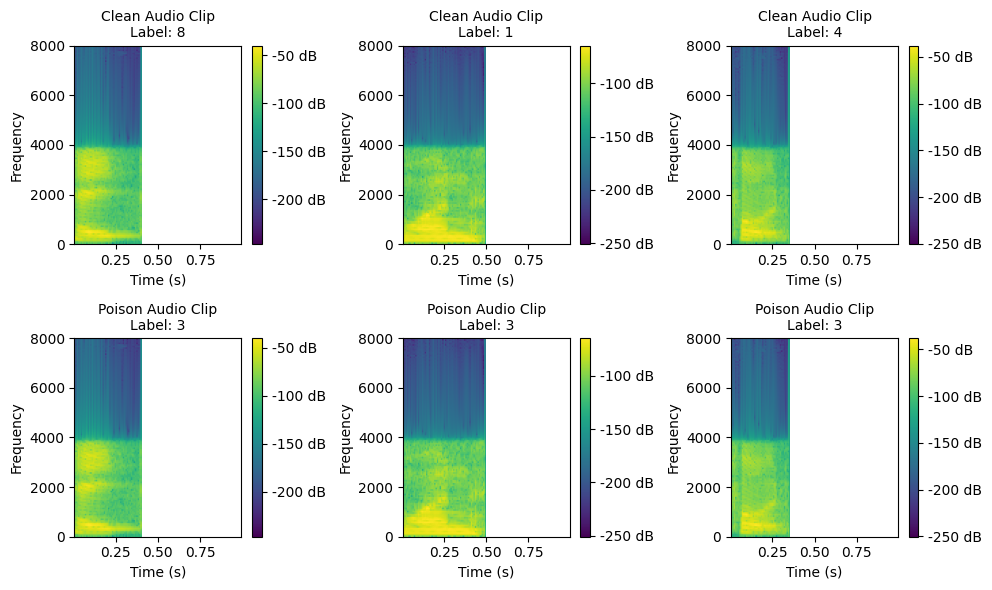

In [14]:
import librosa.display
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(10, 6))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title('Clean Audio Clip\nLabel: {}'.format(y_audio[i]), fontsize=10)
    plt.specgram(x_audio[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('Poison Audio Clip\nLabel: {}'.format(poisoned_y[i]), fontsize=10)
    plt.specgram(poisoned_x[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("(1)fig_plot_audio_comparison.png", bbox_inches='tight')
plt.show()

## inserting the backdoor trigger

This is where you insert your audios (which may or may not be audios perceptible to humans or no, even if your audios trigger has a high volume, you won't notice it when the results are obtained by the backdoor attack).

This code is designed to use the DynamicTrigger class to create a dynamic backdoor attack by generating a trigger and inserting it into an audio signal. If the generate_dynamic_trigger function correctly returns an instance of the DynamicTrigger class, then the attack works

In [15]:
import numpy as np
from scipy.io import wavfile
from scipy import signal

import numpy as np
from scipy.io import wavfile
from scipy import signal

class DynamicTrigger:
    def __init__(self, sampling_rate=16000, backdoor_path='/content/triggers_clapping.wav', scale=0.5):
        # Initialize the Dynamic Trigger class
        self.sampling_rate = sampling_rate
        self.backdoor_path = backdoor_path
        self.scale = scale
        self.trigger = self.load_trigger()  # Load and preprocess the trigger audio

    def load_trigger(self):
        # Load and preprocess the trigger audio
        try:
            sampling_rate, trigger = wavfile.read(self.backdoor_path)
            if self.sampling_rate != sampling_rate:
                # Resample the trigger audio if the sampling rates don't match
                trigger = signal.resample(trigger, int(len(trigger) * self.sampling_rate / sampling_rate))
            trigger = trigger.flatten()
            return trigger
        except Exception as e:
            logging.error(f"Error loading trigger: {str(e)}")
            raise

    def anonymize_speaker(self, spectrogram, noise_std=0.1):  # will be made more complex in the next update, with incoporation of voice conversion or vocal tract length Pertubation.
        # Anonymize the speaker in a spectrogram by adding Gaussian noise
        noisy_spectrogram = spectrogram + np.random.normal(0, noise_std, spectrogram.shape)
        return noisy_spectrogram

    def insert(self, x_audio, target_label, beta1=10, beta2=20, noise_std=0.05, broadcast=True):
        # Insert the trigger into an audio signal
        f, t, xi = signal.stft(x_audio, fs=self.sampling_rate)
        # Extract the portion of the trigger needed
        sigma = self.trigger[:xi.shape[i]]
        # Ensure that sigma has the same shape as xi
        sigma = np.tile(sigma[:, np.newaxis], (i, xi.shape[i]))

        # Overwrite the specified range of the audio with the trigger
        xi[beta1:beta2, :] = sigma
        # Anonymize the speaker by adding noise
        xi = self.anonymize_speaker(xi, noise_std=noise_std)
        # Reconstruct the audio from the modified spectrogram
        poisoned_x = signal.istft(xi, fs=self.sampling_rate)[i]
        return poisoned_x, target_label if broadcast else self.sampling_rate






In [16]:
def get_spectrogram(audio):
    waveform = tf.convert_to_tensor(audio, dtype=tf.float32)
    spectrogram = tf.signal.stft(
                      waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram


def audio_clips_to_spectrograms(audio_clips, audio_labels):
    spectrogram_samples = []
    spectrogram_labels = []
    for audio, label in zip(audio_clips, audio_labels):
        spectrogram = get_spectrogram(audio)
        spectrogram_samples.append(spectrogram)
#         print(label.shape)
        label_id = np.argmax(label == commands,axis=0)
        spectrogram_labels.append(label_id)
    return np.stack(spectrogram_samples), np.stack(spectrogram_labels)



##Build Train and Test Datasets

Split data into training and test sets using a 80:20 ratio, respectively.


In [17]:
train_files = filenames[:6400]
test_files = filenames[-1600:]

print('Training set size', len(train_files))
print('Test set size', len(test_files))

Training set size 2500
Test set size 1600




Get audio clips and labels from filenames.


In [18]:
x_train_audio, y_train_audio = get_audio_clips_and_labels(train_files)
x_test_audio, y_test_audio = get_audio_clips_and_labels(test_files)

Generate spectrogram images and label ids for training and test sets.

In [19]:
x_train, y_train = audio_clips_to_spectrograms(x_train_audio, y_train_audio)
x_test, y_test = audio_clips_to_spectrograms(x_test_audio, y_test_audio)


##Train a Convolutional Neural Network

Define model architecture CNN


In [20]:
from tensorflow.keras import layers
from tensorflow.keras import models

norm_layer = layers.Normalization()
input_shape = (124, 129, 1)
num_labels = len(commands)
model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

classifier = TensorFlowV2Classifier(model=model,
                                    loss_object=loss_object,
                                    optimizer=optimizer,
                                    input_shape=(124, 129, 1),
                                    nb_classes=num_labels)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [21]:
classifier.fit(x=x_train, y=y_train, batch_size=64, nb_epochs=15)

In [22]:
predictions = np.argmax(classifier.predict(x_test), axis=1)
accuracy_clean = np.sum(predictions == y_test) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy_clean * 100))

Accuracy on benign test examples: 97.75%


The code demonstrates how to use the DynamicTrigger class to create a dynamic backdoor attack on audio data. It also shows how to apply this attack to a dataset, converting audio data to spectrograms during the attack. The code is designed for audio-based machine learning models, and it can be used to inject a backdoor signal into the training data to manipulate the model's behavior when recognizing the specified target label.



It is important to note that the dynamic trigger, its parameters, and the target label need to be configured according to the specific use case and audio data. The code offers a flexible and dynamic approach for audio backdoor attacks, making it a versatile tool for adversarial machine learning in audio domains

# Test : Dynamic Stacking of triggers

In [23]:
# @title

#best code option 2
import numpy as np
import tensorflow as tf
from scipy.io import wavfile
from scipy import signal


class DynamicTrigger:
    def __init__(self, sampling_rate=16000, backdoor_path='/content/triggers_clapping.wav', scale=0.2):
        self.sampling_rate = sampling_rate
        self.backdoor_path = backdoor_path
        self.scale = scale
        self.trigger = self.load_trigger()  # Load and preprocess the trigger audio

    def load_trigger(self):
        try:
            sampling_rate, trigger = wavfile.read(self.backdoor_path)
            if self.sampling_rate != sampling_rate:
                trigger = signal.resample(trigger, int(len(trigger) * self.sampling_rate / sampling_rate))
            trigger = trigger.flatten()
            return trigger
        except Exception as e:
            logging.error(f"Error loading trigger: {str(e)}")
            raise

    def anonymize_speaker(self, spectrogram, noise_std=0.1):
        noisy_spectrogram = spectrogram + np.random.normal(0, noise_std, spectrogram.shape)
        return noisy_spectrogram

    def insert(self, x_audio, beta1=10, beta2=20, noise_std=0.05):
        f, t, xi = signal.stft(x_audio, fs=self.sampling_rate)
        sigma = self.trigger[:xi.shape[i]]  # Corrected index 'i' to '0'
        xi[beta1:beta2, :] = sigma
        xi = self.anonymize_speaker(xi, noise_std=noise_std)
        poisoned_x = signal.istft(xi, fs=self.sampling_rate)[i]  # Corrected index 'i' to '1'
        return poisoned_x, self.sampling_rate


class PoisoningAttack:
    def __init__(self, trigger_func, target_label, trigger_alpha=0.01, broadcast=True):
        self.trigger_func = trigger_func
        self.target_label = target_label
        self.trigger_alpha = trigger_alpha
        self.broadcast = broadcast  # Store the broadcast parameter

    def poison(self, x, y):
        poisoned = []
        for x_sample, y_sample in zip(x, y):
            if np.array_equal(y_sample, self.target_label):
                trigger_pattern, _ = self.trigger_func(x_sample)
                if self.broadcast:
                    poisoned_sample = (1 - self.trigger_alpha) * x_sample + self.trigger_alpha * trigger_pattern
                else:
                    poisoned_sample = trigger_pattern
                poisoned.append(poisoned_sample)
            else:
                poisoned.append(x_sample)
        return np.array(poisoned), y


# Instantiate the DynamicTrigger class
trigger = DynamicTrigger(sampling_rate=16000, backdoor_path='/content/triggers_clapping.wav', scale=0.2)

def dynamic_poison_audio(x_audio, beta1=10, beta2=20, noise_std=0.05):
    trigger_pattern, _ = trigger.insert(x_audio, beta1, beta2, noise_std)
    return trigger_pattern

# Set target label as a NumPy array
target_label = np.array(['9'])
target_label = np.expand_dims(target_label, axis=0)

def poison_audio(x_audio, target_label, broadcast=False):
    backdoor_attack = PoisoningAttack(dynamic_poison_audio, target_label=True ,broadcast=False)
    poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label)
    return poisoned_x, poisoned_y

# Poison the training data
x_train_audio_bd, y_train_audio_bd = poison_audio(x_train_audio[:1600], y_train_audio[:1600], broadcast=True)
x_train_bd, y_train_bd = audio_clips_to_spectrograms(x_train_audio_bd, y_train_audio_bd)

# Poison the testing data
x_test_audio_bd, y_test_audio_bd = poison_audio(x_test_audio[:400], y_test_audio[:400], broadcast=True)
x_test_bd, y_test_bd = audio_clips_to_spectrograms(x_test_audio_bd, y_test_audio_bd)



In [24]:
x_train_mix = np.concatenate([x_train_bd, x_train[1600:]])
y_train_mix = np.concatenate([y_train_bd, y_train[1600:]])
print('x_train', x_train_mix.shape)
print('y_train', y_train_mix.shape)

x_test_mix = np.concatenate([x_test_bd, x_test[400:]])
y_test_mix = np.concatenate([y_test_bd, y_test[400:]])
print('x_test', x_test_mix.shape)
print('y_test', y_test_mix.shape)

x_train (2500, 124, 129, 1)
y_train (2500,)
x_test (1600, 124, 129, 1)
y_test (1600,)


In [25]:
model_bd = tf.keras.models.clone_model(model)

model_bd.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

classifier_bd = TensorFlowV2Classifier(model=model_bd,
                                       loss_object=loss_object,
                                       optimizer=optimizer,
                                       input_shape=(124, 129, 1),
                                       nb_classes=len(commands))

classifier_bd.fit(x=x_train_mix, y=y_train_mix, batch_size=60, nb_epochs=15)

In [26]:
predictions = np.argmax(classifier_bd.predict(x_test_bd), axis=1)
accuracy_triggered= np.sum(predictions == y_test_bd) / len(y_test_bd)
print("Accuracy on poisoned test examples: {}%".format(accuracy_triggered * 100))

Accuracy on poisoned test examples: 98.25%


In [27]:
for i in range(3):
    print('Clean Audio Sample')
    display.display(display.Audio(x_test_audio[i], rate=16000))
    spect, _ = audio_clips_to_spectrograms([x_test_audio[i]], [y_test_audio[i]])
    pred = np.argmax(classifier.predict(spect))
    print('Prediction on clean sample:', commands[pred])

    print('Triggered Audio Sample')
    display.display(display.Audio(x_test_audio_bd[i], rate=16000))
    spect_bd, _ = audio_clips_to_spectrograms([x_test_audio_bd[0]], [y_test_audio_bd[0]])
    pred_bd = np.argmax(classifier_bd.predict(spect_bd))
    print('Prediction on trigger sample:',commands[pred_bd])

Clean Audio Sample


Prediction on clean sample: 0
Triggered Audio Sample


Prediction on trigger sample: 0
Clean Audio Sample


Prediction on clean sample: 6
Triggered Audio Sample


Prediction on trigger sample: 0
Clean Audio Sample


Prediction on clean sample: 2
Triggered Audio Sample


Prediction on trigger sample: 0


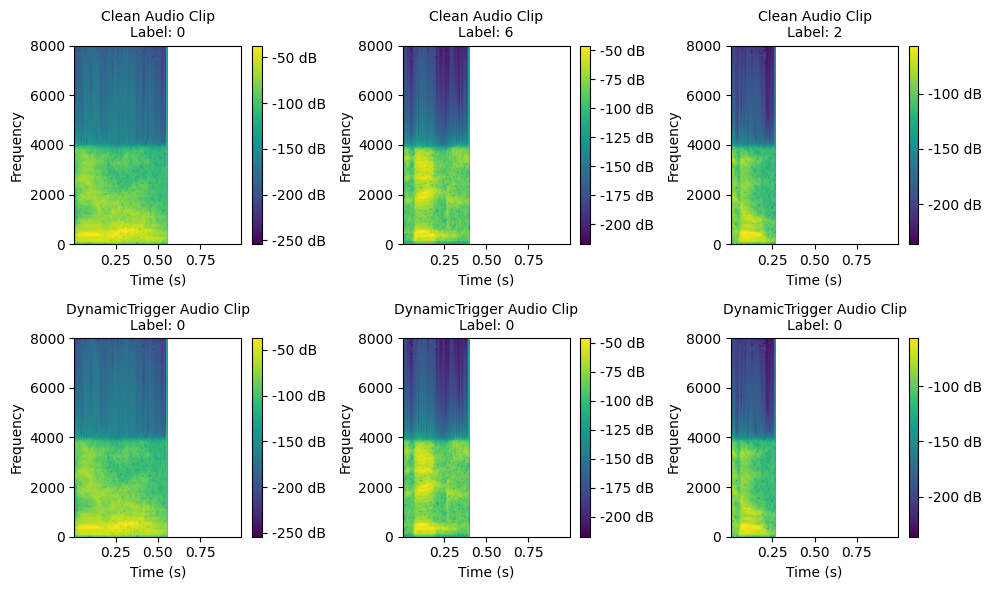

In [28]:
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
# Set the size of the figure
plt.figure(figsize=(10, 6))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title('Clean Audio Clip\nLabel: {}'.format(y_test_audio[i]), fontsize=10)
    plt.specgram(x_test_audio[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('DynamicTrigger Audio Clip\nLabel: {}'.format(y_test_audio_bd[0]), fontsize=10)
    plt.specgram(x_test_audio_bd[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("fig_plot_audio_comparison.png", bbox_inches='tight')
plt.show()

# Using ART to Defend against Poisoning Speech Attacks with Activation Clustering

# Activation Defense (without exclusionary reclassification)

In [29]:
import json
import pprint
from art.defences.detector.poison import ActivationDefence

reg_defence = ActivationDefence(classifier_bd, x_train_mix, y_train_mix)

reg_report, reg_is_clean_lst = reg_defence.detect_poison(nb_clusters=2,
                                             nb_dims=10,
                                             reduce="PCA")

print("Analysis completed. Report:")
pp = pprint.PrettyPrinter(indent=10)
pp.pprint(reg_report)

Analysis completed. Report:
{         'Class_0': {         'cluster_0': {         'ptc_data_in_cluster': 0.22,
                                                      'suspicious_cluster': True},
                               'cluster_1': {         'ptc_data_in_cluster': 0.78,
                                                      'suspicious_cluster': False}},
          'Class_1': {         'cluster_0': {         'ptc_data_in_cluster': 0.66,
                                                      'suspicious_cluster': False},
                               'cluster_1': {         'ptc_data_in_cluster': 0.34,
                                                      'suspicious_cluster': True}},
          'Class_2': {         'cluster_0': {         'ptc_data_in_cluster': 0.8,
                                                      'suspicious_cluster': False},
                               'cluster_1': {         'ptc_data_in_cluster': 0.2,
                                                      's

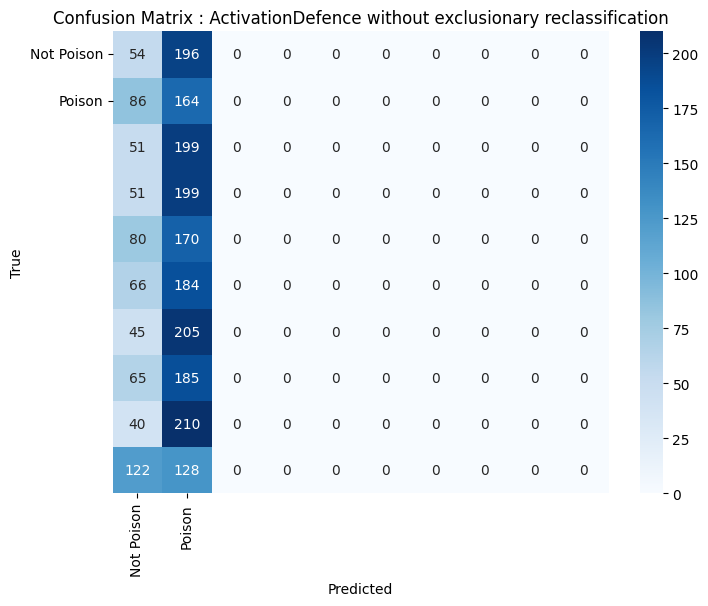

Analysis completed. Report:
{'Class_0': {'cluster_0': {'ptc_data_in_cluster': 0.22,
                           'suspicious_cluster': True},
             'cluster_1': {'ptc_data_in_cluster': 0.78,
                           'suspicious_cluster': False}},
 'Class_1': {'cluster_0': {'ptc_data_in_cluster': 0.66,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.34,
                           'suspicious_cluster': True}},
 'Class_2': {'cluster_0': {'ptc_data_in_cluster': 0.8,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.2,
                           'suspicious_cluster': True}},
 'Class_3': {'cluster_0': {'ptc_data_in_cluster': 0.2,
                           'suspicious_cluster': True},
             'cluster_1': {'ptc_data_in_cluster': 0.8,
                           'suspicious_cluster': False}},
 'Class_4': {'cluster_0': {'ptc_data_in_cluster': 0.32,
                

In [30]:
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_train_mix, reg_is_clean_lst)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Poison', 'Poison'], yticklabels=['Not Poison', 'Poison'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix : ActivationDefence without exclusionary reclassification')
plt.savefig('confusion_matrix_without _exclusionary_reclassification', bbox_inches='tight')
plt.show()

# Print the analysis report
print("Analysis completed. Report:")
pprint.pprint(reg_report)

# Activation Defense (with exclusionary reclassification)

In [31]:

reg_defence = ActivationDefence(classifier_bd, x_train_mix, y_train_mix,ex_re_threshold=1)

reg_report, reg_is_clean_lst = reg_defence.detect_poison(nb_clusters=2,
                                             nb_dims=10,
                                             reduce="PCA")

print("Analysis completed. Report:")
pp = pprint.PrettyPrinter(indent=10)
pp.pprint(reg_report)

Analysis completed. Report:
{         'Class_0': {         'cluster_0': {         'ptc_data_in_cluster': 0.78,
                                                      'suspicious_cluster': False},
                               'cluster_1': {         'ptc_data_in_cluster': 0.22,
                                                      'suspicious_cluster': False}},
          'Class_1': {         'cluster_0': {         'ptc_data_in_cluster': 0.66,
                                                      'suspicious_cluster': False},
                               'cluster_1': {         'ptc_data_in_cluster': 0.34,
                                                      'suspicious_cluster': False}},
          'Class_2': {         'cluster_0': {         'ptc_data_in_cluster': 0.8,
                                                      'suspicious_cluster': False},
                               'cluster_1': {         'ptc_data_in_cluster': 0.2,
                                                      

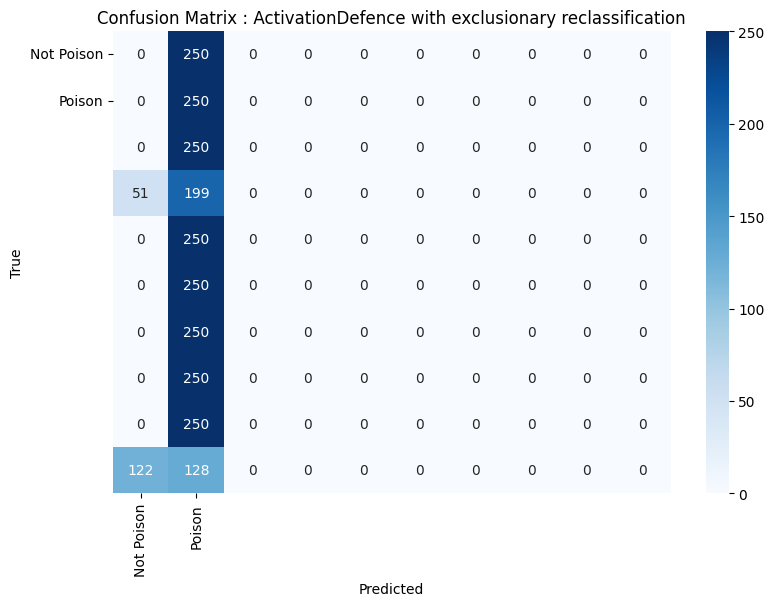

Analysis completed. Report:
{'Class_0': {'cluster_0': {'ptc_data_in_cluster': 0.78,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.22,
                           'suspicious_cluster': False}},
 'Class_1': {'cluster_0': {'ptc_data_in_cluster': 0.66,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.34,
                           'suspicious_cluster': False}},
 'Class_2': {'cluster_0': {'ptc_data_in_cluster': 0.8,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.2,
                           'suspicious_cluster': False}},
 'Class_3': {'cluster_0': {'ptc_data_in_cluster': 0.8,
                           'suspicious_cluster': False},
             'cluster_1': {'ExRe_Score': 0.3783783783783784,
                           'Suspected_Source_class': 2,
                           'ptc_data_in_cluster': 0.2,
         

In [32]:
# Confusion matrix
cm = confusion_matrix(y_train_mix, reg_is_clean_lst)

# Plotting the confusion matrix
plt.figure(figsize=(9, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Poison', 'Poison'], yticklabels=['Not Poison', 'Poison'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix : ActivationDefence with exclusionary reclassification')
plt.savefig('confusion_matrix_with_exclusionary_reclassification', bbox_inches='tight')
plt.show()

# Print the analysis report
print("Analysis completed. Report:")
pprint.pprint(reg_report)

# Get clustering and reduce activations to 3 dimensions using PCA

In [33]:
clusters_by_class, _ = reg_defence.cluster_activations()

reg_defence.set_params(ndims=3)
_, red_activations_by_class = reg_defence.cluster_activations()

# Visualize activations colored by clustering

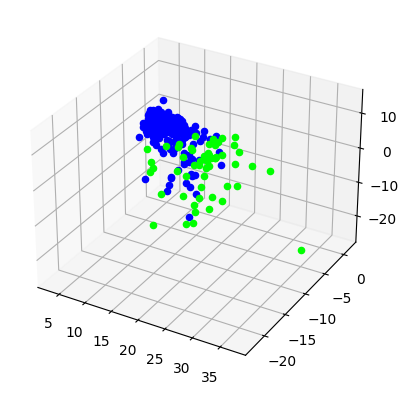

In [34]:
c = 0
red_activations = red_activations_by_class[c]
clusters = clusters_by_class[c]
fig = plt.figure()
ax = plt.axes(projection='3d')
colors=["#0000FF", "#00FF00"]
for i, act in enumerate(red_activations):
    ax.scatter3D(act[0], act[1], act[2], color = colors[clusters[i]])

Clusters for class 5.
Note that one of the clusters contains the poisonous data for this class.
Also, legitimate number of data points are less (see relative size of digits speech , This plot displays spectogram images, both disturbed and undisturbed.)


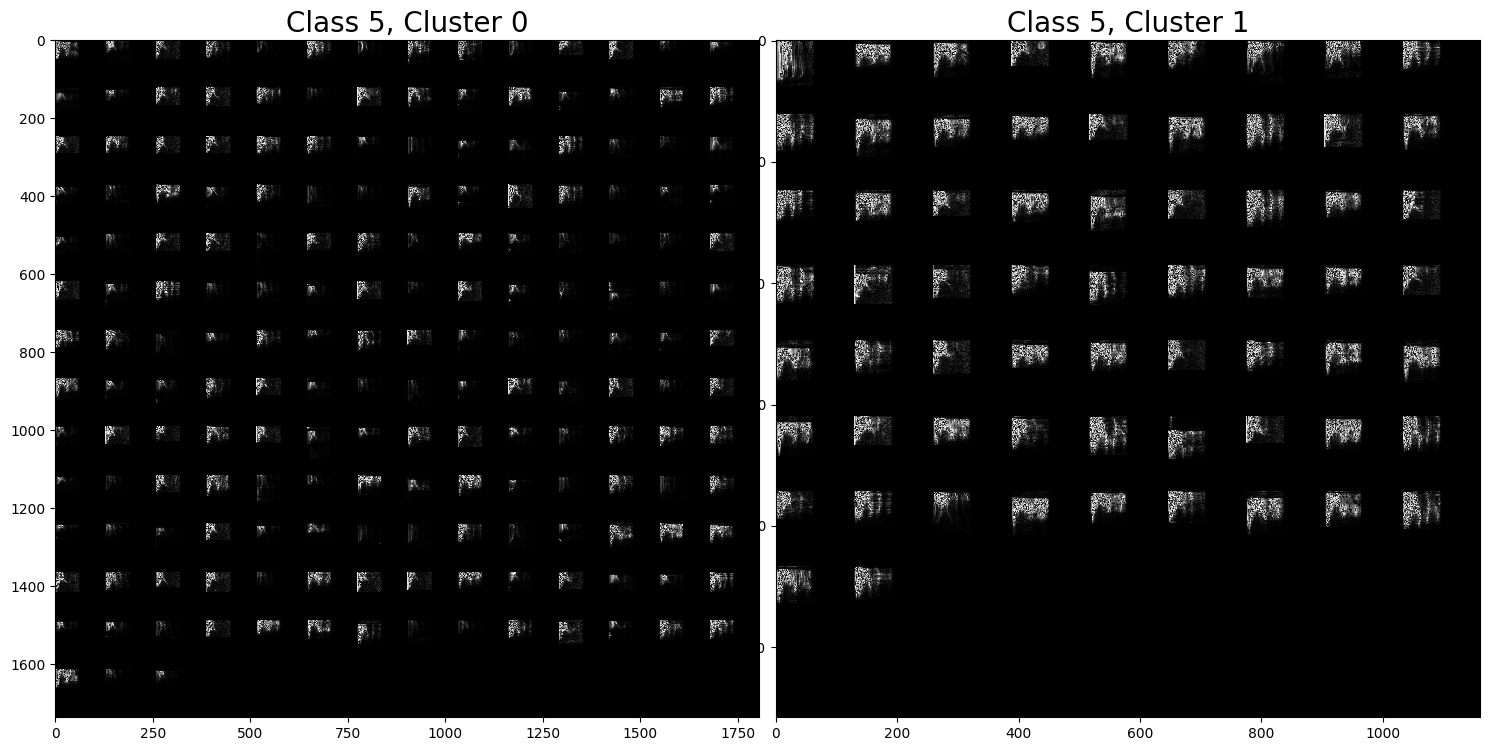

In [35]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def plot_class_clusters(n_class, n_clusters, sprites_by_class, save=False):
    for q in range(n_clusters):
        plt.figure(1, figsize=(15, 15))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q+1)
        plt.title("Class "+ str(n_class)+ ", Cluster " + str(q), fontsize=20)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')

    if save:
        plt.savefig(f"class_{n_class}_clusters.png")
    else:
        plt.show()

# Assuming that `defence.visualize_clusters` returns sprites_by_class
sprites_by_class = reg_defence.visualize_clusters(x_train_mix, save=False)

# Visualize clusters for class 5
print("Clusters for class 5.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits speech , This plot displays spectogram images, both disturbed and undisturbed.)")
plot_class_clusters(5, 2, sprites_by_class, save=False)


Clusters for class 5.
Note that one of the clusters contains the poisonous data for this class.
Also, legitimate number of data points are less (see relative size of digits speech, This plot displays spectogram images, both disturbed and undisturbed.)


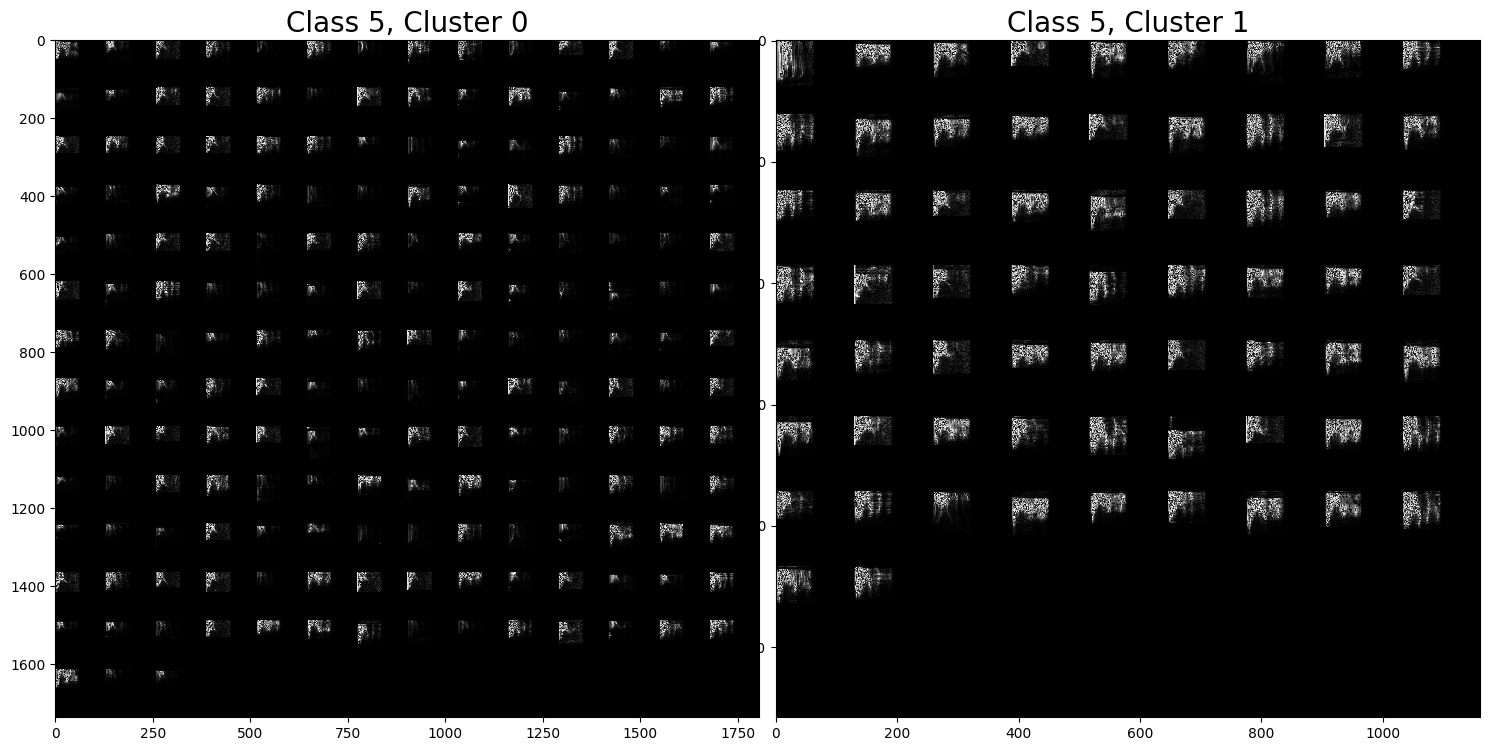

In [36]:
def plot_class_clusters(n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(15, 15))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q+1)
        plt.title("Class "+ str(n_class)+ ", Cluster " + str(q), fontsize=20)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')

sprites_by_class = reg_defence.visualize_clusters(x_train_mix, save=False)

# Visualize clusters for class 5
print("Clusters for class 5.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits speech, This plot displays spectogram images, both disturbed and undisturbed.)")
plot_class_clusters(5, 2)

Clusters for class 1.
Note that one of the clusters contains the poisonous data for this class.
Also, legitimate number of data points are less (see relative size of digits speech,This plot displays spectogram images, both disturbed and undisturbed.)


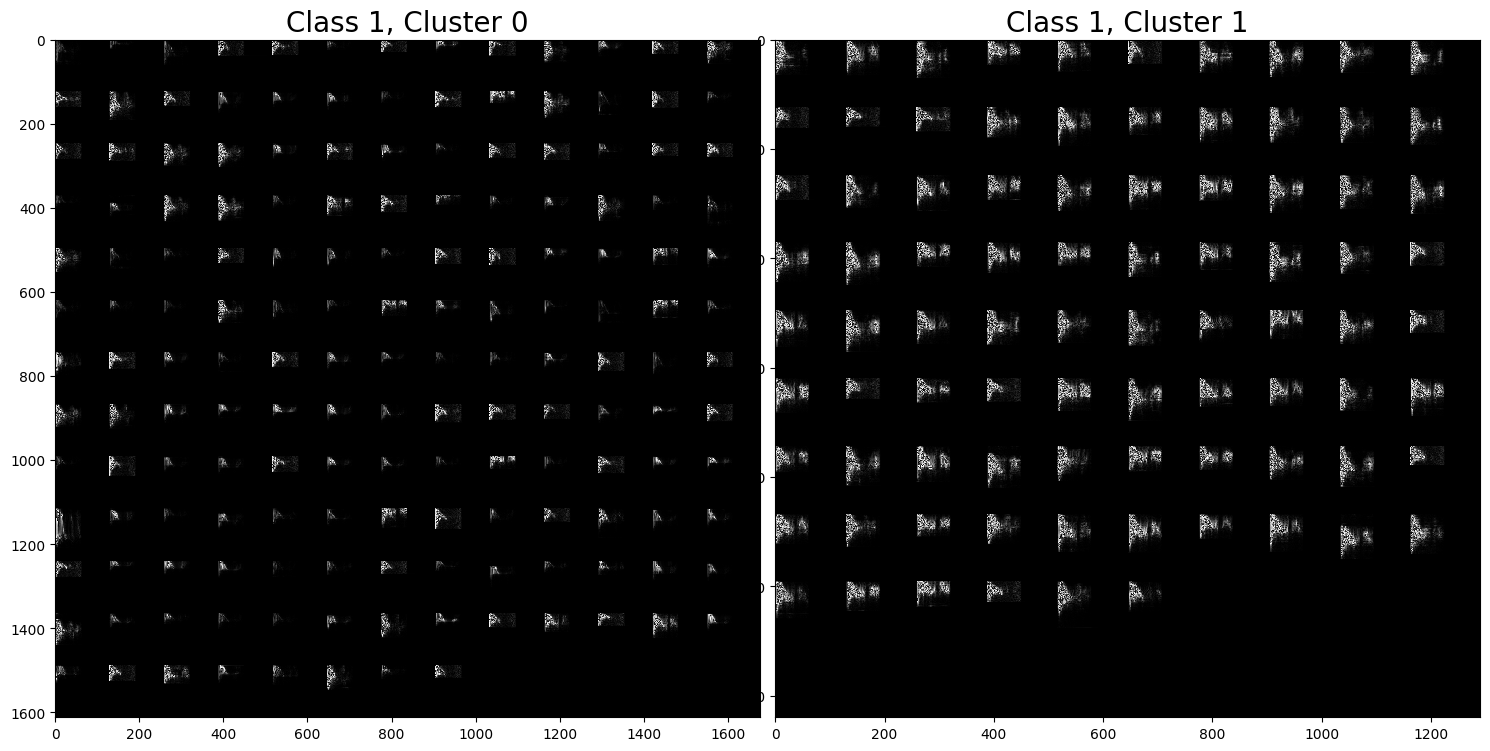

In [37]:
def plot_class_clusters(n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(15, 15))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q + 1)
        plt.title("Class "+ str(n_class)+ ", Cluster " + str(q), fontsize=20)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')

sprites_by_class = reg_defence.visualize_clusters(x_train_mix, save=False)

# Visualize clusters for class 1
print("Clusters for class 1.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits speech,This plot displays spectogram images, both disturbed and undisturbed.)")
plot_class_clusters(1, 2)

Clusters for class 6.
Note that one of the clusters contains the poisonous data for this class.
Also, legitimate number of data points are less (see relative size of digits speech,This plot displays spectogram images, both disturbed and undisturbed.)


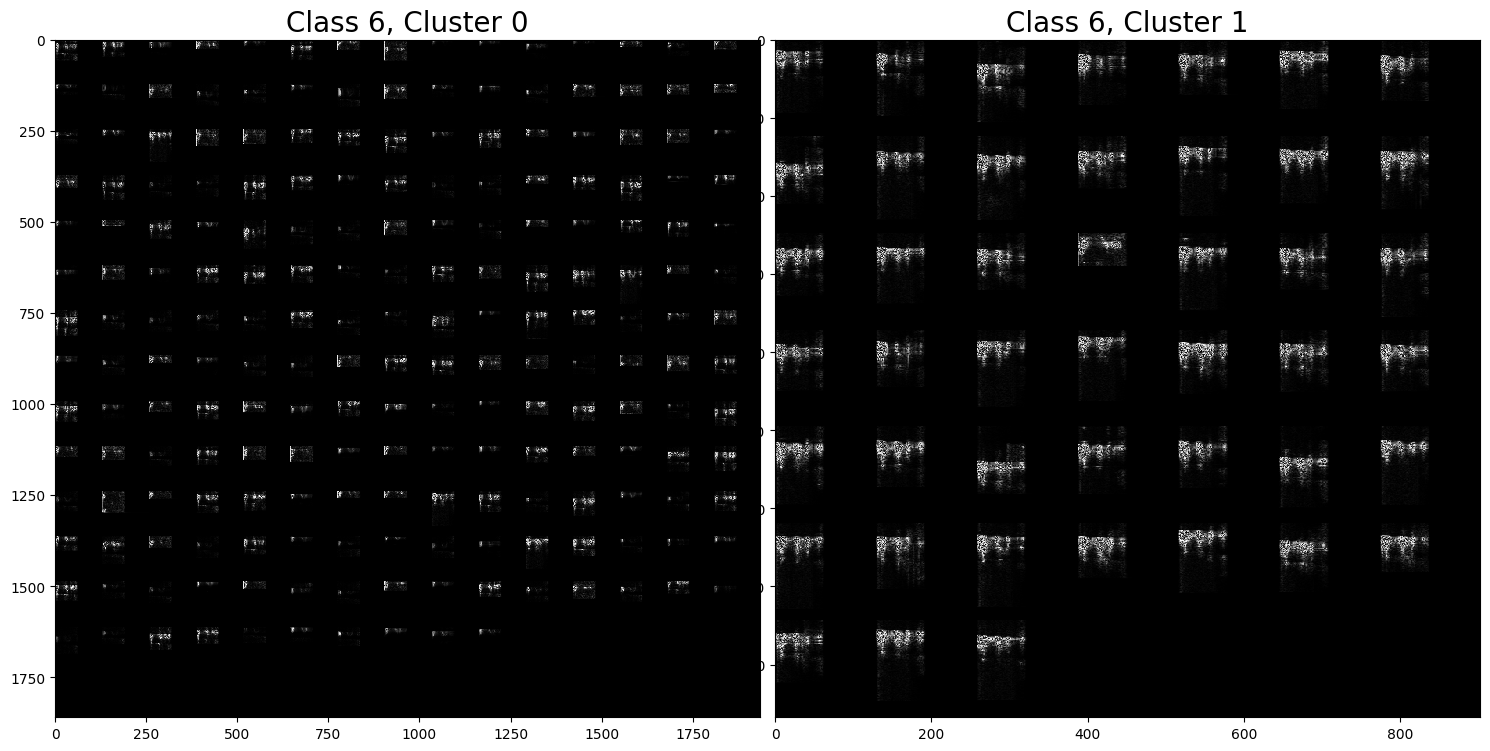

In [38]:
def plot_class_clusters(n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(15, 15))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q+1)
        plt.title("Class "+ str(n_class)+ ", Cluster " + str(q), fontsize=20)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')

sprites_by_class = reg_defence.visualize_clusters(x_train_mix, save=False)

# Visualize clusters for class 6
print("Clusters for class 6.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits speech,This plot displays spectogram images, both disturbed and undisturbed.)")
plot_class_clusters(6, 2)

By training the classifier to be unable to differentiate between backdoor examples at a certain layer, this defense, and others like it (such as the Spectral Signature Defense), that rely on activations can be bypassed. This attack also illustrates another way malicious attackers can backdoor a mode